In [38]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import gridspec
import h5py
import geohash
from sklearn.cluster import KMeans
import json

In [6]:
#Load raw data
data = pd.read_csv('../raw_data/training.csv' ,sep=",")

In [11]:
coord = data.groupby(['geohash6']).size().reset_index(name='counts')

# all unique geohash6
coord_array = coord['geohash6'].values

In [12]:
coord_array

array(['qp02yc', 'qp02yf', 'qp02yu', ..., 'qp0dnh', 'qp0dnj', 'qp0dnn'],
      dtype=object)

In [10]:
# decode all unique geohash6 to latitue and longitude

gps = np.zeros((len(coord_array), 2))
for idx in range(len(coord_array)):
    
    tup = geohash.decode(coord_array[idx])
    gps[idx][0] = float(tup[0])
    gps[idx][1] = float(tup[1])
gps

array([[-5.48492432, 90.65368652],
       [-5.47943115, 90.65368652],
       [-5.46844482, 90.65368652],
       ...,
       [-5.24871826, 90.97229004],
       [-5.2432251 , 90.97229004],
       [-5.23773193, 90.97229004]])

In [13]:
# Using K-means algorithm to look for clusters in locations

num_clusters = 8
est = KMeans(n_clusters= num_clusters)
est.fit(gps)

gps_label = est.predict(gps)

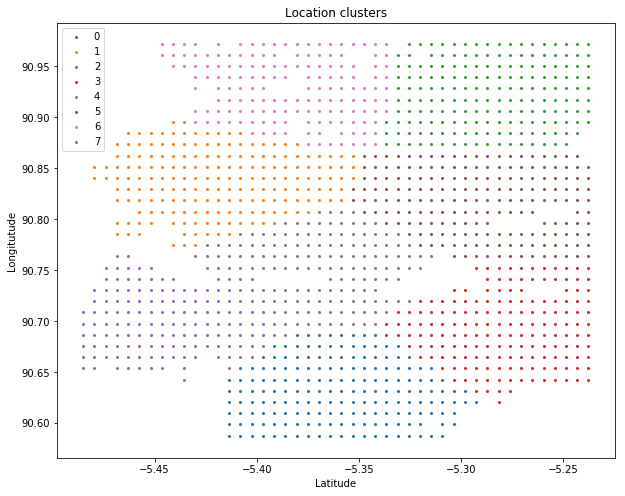

In [15]:
# plot the different clusters identified by K-means

label_type = range(num_clusters)

fig, ax = plt.subplots(figsize = (10,8))

for label in label_type:
    ax.scatter(
        gps[gps_label == label, 0], 
        gps[gps_label == label, 1],label = label, s=4)
    
plt.title('Location clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitutude')
ax.legend()
plt.show()

In [16]:
# Rearranging the geohash6 in coord_array according to cluster label. 
#All geohash6 with the same cluster label will be grouped together

#feature_idx stores the start and end index of the geohash in coord_array for each cluster.
#The feature_idx for a coord_array with num_clusters = 3 may look something like [(0, 500), (500, 1000), (1000, 1329)]

gps_frame = pd.DataFrame( {'geohash6': coord_array, 'label': gps_label})

feature_idx = []
gps_list = []

start_feature_idx = 0

for label in label_type:

    cluster = gps_frame[gps_frame['label']==label]['geohash6'].values
    gps_list.append(cluster)
    
    end_feature_idx = start_feature_idx + len(cluster)
    feature_idx.append( (start_feature_idx, end_feature_idx))
    
    start_feature_idx = end_feature_idx
    
coord_array = np.concatenate(gps_list)

In [17]:
coord_array

array(['qp03jq', 'qp03jr', 'qp03jw', ..., 'qp09d3', 'qp09d4', 'qp09d5'],
      dtype=object)

In [18]:
feature_idx

[(0, 178),
 (178, 361),
 (361, 539),
 (539, 706),
 (706, 844),
 (844, 1029),
 (1029, 1182),
 (1182, 1329)]

In [23]:
# Create index dict of coord 
coord_dict = {}

for i, j in enumerate(coord_array):
    coord_dict[j] = i

In [24]:
# Save coord_dict and feature_idx information to desk as they are needed to process unseen data
# Already saved in ../processed_data as geohash_8c.json


In [25]:
# Create index dict of unique time stamps in raw data

daytime_dict = {}
count = 0
for day in range( data['day'].min(), data['day'].max() + 1 ):
    for hour in range(0, 24):
        for mins in [0, 15, 30, 45]:
            
            daytime = '{},{}:{}'.format(day, hour, mins)
            daytime_dict[daytime] = count
            
            count += 1
            

In [26]:
# initialize nested list to create data array of (timesteps in time order, total_num_geohash6 )

row = len(daytime_dict)
col = len(coord_dict)

assert col == 1329, 'number of unique geohashs in test set must be the same as that of the training set'

data_nested_list =[]

for i in range(row):
    
    data_nested_list.append([0 for j in range(col)])

In [27]:
# store all values in array
geohash_array = data['geohash6'].values
daytime_array = data['day'].astype(str).values + ',' + data['timestamp'].values
demand_array = data['demand'].values

In [29]:
# append values to nested list

for idx in range(len(data)):
    
    row_idx = daytime_dict[daytime_array[idx] ]
    col_idx = coord_dict[geohash_array[idx] ]
    
    data_nested_list[row_idx][col_idx] = demand_array[idx]

In [30]:
# create data array
data_array = np.array(data_nested_list)

In [88]:
# save data array to file
# Already saved in ../processed_data as train_processed_8c.h5

In [31]:
daytime_list = []
count = 0
for day in range(1, 62):
    for hour in range(0, 24):
        for mins in [0, 15, 30, 45]:
            
            daytime = '{},{}:{}'.format(day, hour, mins)
            daytime_list.append(daytime)
            
daytime_list = np.array(daytime_list)

In [61]:
coord_dict_rev = {v: k for k, v in coord_dict.items()}

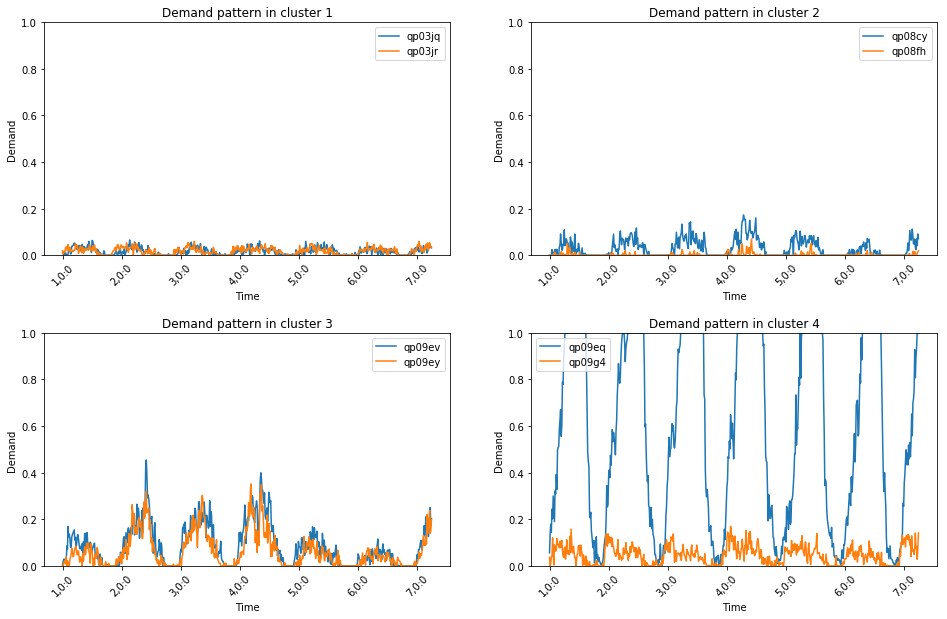

In [85]:
plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(4, 4, hspace=1.0, wspace=0.5)

ax = plt.subplot(gs[:2 , :2])
plt.plot(data_array[:600, 0], label = coord_dict_rev[0])
plt.plot(data_array[:600, 1], label = coord_dict_rev[1])
plt.xticks( steps , daytime_list[steps.tolist()], rotation=45 )
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand pattern in cluster 1')
ax.set_ylim(0, 1)
ax.legend()

ax = plt.subplot(gs[:2 , 2:])
plt.plot(data_array[:600, 180], label = coord_dict_rev[180])
plt.plot(data_array[:600, 181], label = coord_dict_rev[181])
plt.xlabel('Time')
plt.ylabel('Demand')
plt.xticks( steps , daytime_list[steps.tolist()], rotation=45 )
plt.title('Demand pattern in cluster 2')
ax.set_ylim(0, 1)
ax.legend()

ax = plt.subplot(gs[2: , :2])
plt.plot(data_array[:600, 362], label = coord_dict_rev[362])
plt.plot(data_array[:600, 363], label = coord_dict_rev[363])
plt.xlabel('Time')
plt.ylabel('Demand')
plt.xticks( steps , daytime_list[steps.tolist()], rotation=45 )
plt.title('Demand pattern in cluster 3')
ax.set_ylim(0, 1)
ax.legend()

ax = plt.subplot(gs[2: , 2:])
plt.plot(data_array[:600, 905], label = coord_dict_rev[905])
plt.plot(data_array[:600, 945], label = coord_dict_rev[945])
plt.xlabel('Time')
plt.ylabel('Demand')
plt.xticks( steps , daytime_list[steps.tolist()], rotation=45 )
plt.title('Demand pattern in cluster 4')
ax.set_ylim(0, 1)
ax.legend()



plt.show()